In [9]:
import torch
CPU = torch.device('cpu')
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    device = torch.device('cuda')
else:
    torch.set_default_tensor_type(torch.FloatTensor)
    device = CPU
print("device =", device)

import autograd.numpy as np
np.random.seed(0)
np.seterr(all='raise')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import time
from sklearn import preprocessing
from functools import partial

import sys; sys.path.insert(0, '..')
from osmm.osmm import OSMM

device = cpu


In [10]:
dataset = "kelly"
from examples.kelly import *
my_objf = my_objf_torch_kelly
generate_random_data = generate_horse_race_return
get_baseline_soln_cvxpy = get_baseline_soln_kelly
get_cvxpy_description = get_cvxpy_description_kelly
get_initial_val = get_initial_val_kelly
my_plot_one_result = my_plot_kelly_one_result
get_baseline_soln_mosek = get_baseline_soln_kelly_mosek

In [11]:
W = generate_random_data()
W_validation = generate_random_data()

In [12]:
methods = OSMM(f_torch=my_objf, g_cvxpy = get_cvxpy_description, get_initial_val=get_initial_val, 
               W=W, W_validate = W)

In [13]:
methods.solve()

Hutchinson #iters 15 rel. incr. 0.000374703497698904 est. tr. 15553.182955157012
lam_0 88.37035769975574 Hutchinson time cost,  0.06461620330810547


/Users/xinyueshen/anaconda3/lib/python3.7/site-packages/cvxpy/reductions/solvers/solving_chain.py:163: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


iter= 10 objf_k+1= 0.10547618567943573 L_k+1= -0.15456703565724172 lam_k+1= 1.3085045081945608 tk= 0.5 mu_k+1 1.371896838400001 ||G_k+1||_F= 57.94263159028578 tau_k+1 0.9537922032976089
iter= 20 objf_k+1= -0.06609846651554108 L_k+1= -0.10325649181056089 lam_k+1= 0.4116586683858311 tk= 1.0 mu_k+1 0.20254616437047457 ||G_k+1||_F= 84.58200046421352 tau_k+1 2.0324189779909707
iter= 30 objf_k+1= -0.07714994251728058 L_k+1= -0.08483753895003351 lam_k+1= 0.2055890336714304 tk= 0.5 mu_k+1 0.029903814596611625 ||G_k+1||_F= 155.56360850964325 tau_k+1 6.875010310381121
iter= 40 objf_k+1= -0.07927832752466202 L_k+1= -0.07990727170724578 lam_k+1= 0.03602917893505957 tk= 1.0 mu_k+1 0.0044149842590594955 ||G_k+1||_F= 169.48604075524943 tau_k+1 8.160658525821043
      Time elapsed (secs): 2.552754.



In [14]:
x_soln = methods.method_results["x_best"]

../examples/kelly.py:171: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  a.stem([i for i in range(n - 1)], outcomes_count[0:n - 1] / N, markerfmt=' ')
../examples/kelly.py:183: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  b.stem([i for i in range(n)], x_best, markerfmt=' ')


mean 0.07929244491357147


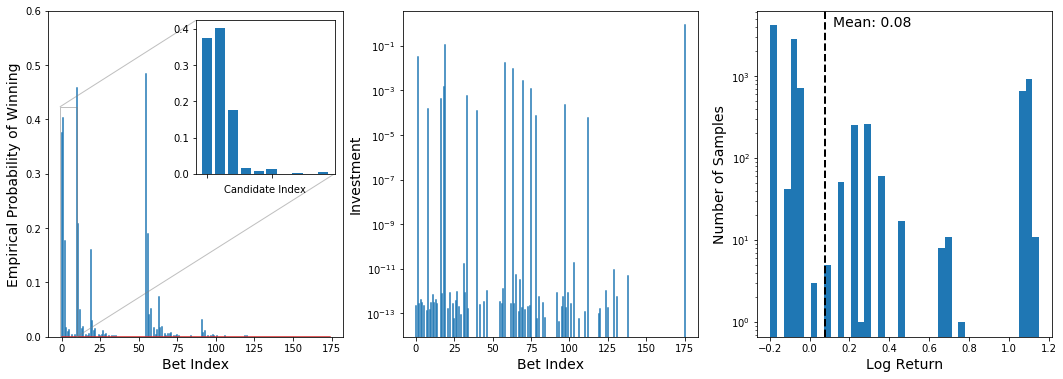

In [15]:
my_plot_one_result(W, x_soln, is_save_fig=False, figname="cvar_pnt9_result.pdf")